# MLWorkbench Magics

The MLWorkbench Magics are a set of Datalab magic functions that allow an easy code-free experience to training, deploying, and predicting ML models. This notebook will take the cleaned data from the previous notebook and build a text classification model. The MLWorkbench Magics are a collection of magic commands for each step in ML workflows: analyzing input data to build transforms, transforming data, training a model, evaluating a model, and deploying a model. This notebook will showcase each step locally. The 20 newsgroup data is too small to need cloud services, but the magic commands can easily be used to start cloud jobs on large datasets.

The commands in this notebook run the sample without calling ML Engine services. The next notebook in this sequence shows the cloud version of these commands and uses Google Cloud Platform.

If you changed the WORKSPACE_PATH variable in the previous notebook, you must also change it here. If you made no modifications, there is no need to update the next cell. The previous notebook must be executed before this one.

In [127]:
WORKSPACE_PATH = '/content/workspace/text_classification_20newsgroup'

In [128]:
import google.datalab.contrib.mlworkbench.commands  # This loads the '%%ml' magics
import os

In [129]:
# Make some constant file paths

# Input files
train_csv_file = os.path.join(WORKSPACE_PATH, 'news_clean_train.csv')
eval_csv_file = os.path.join(WORKSPACE_PATH, 'news_clean_test.csv')

# For analyze step
analyze_output = os.path.join(WORKSPACE_PATH, 'analyze_output')

# For the transform step
transform_output = os.path.join(WORKSPACE_PATH, 'transform_output')
transformed_train_pattern = os.path.join(transform_output, 'features_train*')
transformed_eval_pattern = os.path.join(transform_output, 'features_eval*')

# For the training step
training_output = os.path.join(WORKSPACE_PATH, 'training_output')

# For the prediction steps
batch_predict_output = os.path.join(WORKSPACE_PATH, 'batch_predict_output')
evaluation_model = os.path.join(training_output, 'evaluation_model')
regular_model = os.path.join(training_output, 'model')

# Step 1: Analyze the csv file
The first step in the MLWorkbench workflow is to analyze the data for the requested transformations. We are going to build a bag of words representation on the text and use this in a linear model. Therefore, the analyze step will compute the vocabularies and related statistics of the data for traing.

In [130]:
%%ml analyze
output: $analyze_output
training_data:
  csv: $train_csv_file
  schema:
    - name: news_label
      type: STRING
    - name: text
      type: STRING
features:
  news_label:
    transform: target
  text:
    transform: bag_of_words

Expanding any file patterns...
file list computed.
Analyzing file /content/workspace/text_classification_20newsgroup/news_clean_train.csv...
file /content/workspace/text_classification_20newsgroup/news_clean_train.csv analyzed.


In [131]:
!ls $analyze_output

features.json  schema.json  stats.json	vocab_news_label.csv  vocab_text.csv


# Step 2: Transforming the input data

This step is optional as training can start from csv data (the same data used in the analysis step). The transform step performs some transformations on the input data and saves the results to a special TensorFlow file called a TFRecord file containing TF.Example protocall buffers. This allows training to start from preprocessed data. If this step is not used, training would have to perform the same preprocessing on every row of csv data every time it is used. As TensorFlow reads the same data row multiple times during training, this means the same row would be preprocessed multiple times. By writing the preprocessed data to disk, we can improve training performance. Because the the 20 newsgroups data is small, this step does not matter, but we do it anyway for illustration. This step is recommended if there are text column in a dataset, and required if there are image columns in a dataset.

We run the transform step for the training and eval data.

In [132]:
%%ml transform --shuffle
output: $transform_output
analysis: $analyze_output
prefix: features_train
training_data:
  csv: $train_csv_file

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
2017-07-24 17:47:51.096813: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-24 17:47:51.096841: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-24 17:47:51.096852: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-07-24 17:47:51.096861: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 i

In [133]:
%%ml transform 
output: $transform_output
analysis: $analyze_output
prefix: features_eval
training_data:
  csv: $eval_csv_file

2017-07-24 17:47:59.195964: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-24 17:47:59.195992: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-24 17:47:59.196003: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-07-24 17:47:59.196012: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-07-24 17:47:59.196022: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

Note how more than 1 file may have been made for training and eval. Sharding an input file can improve TensorFlow training performance, especially when running on a distributed cluster. 

In [134]:
!ls $transform_output

errors_features_eval-00000-of-00001.txt
errors_features_train-00000-of-00001.txt
features_eval-00000-of-00008.tfrecord.gz
features_eval-00001-of-00008.tfrecord.gz
features_eval-00002-of-00008.tfrecord.gz
features_eval-00003-of-00008.tfrecord.gz
features_eval-00004-of-00008.tfrecord.gz
features_eval-00005-of-00008.tfrecord.gz
features_eval-00006-of-00008.tfrecord.gz
features_eval-00007-of-00008.tfrecord.gz
features_train-00000-of-00001.tfrecord.gz


An errors file is always written, even if there are no errors. Let's check the error files are empty.

In [135]:
!wc -l $transform_output/errors*

0 /content/workspace/text_classification_20newsgroup/transform_output/errors_features_eval-00000-of-00001.txt
0 /content/workspace/text_classification_20newsgroup/transform_output/errors_features_train-00000-of-00001.txt
0 total


# Step 3: Training a TensorFlow model
MLWorkbench automatically builds standard TensorFlow models without you having to write any TensorFlow code. 

In [136]:
# Training should use an empty output folder. So if you run training multiple times,
# use different folders or remove the output from the previous run.
!rm -fr $training_output

In [137]:
%%ml train
output: $training_output
analysis: $analyze_output
training_data:
  transformed: $transformed_train_pattern
evaluation_data:
  transformed: $transformed_eval_pattern
model_args:
  l2-regularization: 5
  model: linear_classification
  top-n: 4
  learning-rate: 1
  max-steps: 5000
  train-batch-size: 500
  eval-batch-size: 500
  save-checkpoints-secs: 60

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 60, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7ea5c01e90>, '_model_dir': '/content/workspace/text_classification_20newsgroup/training_output/train', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Als

The output of training is two models, one in training_output/model and another in training_output/evaluation_model. These tensorflow models are identical except the latter assumes the target column is part of the input and copies the target value to the output. Therefore, the latter is ideal for evaluation

In [138]:
!ls $training_output

evaluation_model  model  schema_without_target.json  train


# Step 4: Evaluation using batch prediction

Below, we use the evaluation model and run batch prediction locally. Batch prediction is good for large datasets where the data cannot fit in memory or when you want to limit peak memory usage.

In [139]:
%%ml batch_predict
model: $evaluation_model
output: $batch_predict_output
format: json
prediction_data:
  csv: $eval_csv_file

local prediction...
INFO:tensorflow:Restoring parameters from /content/workspace/text_classification_20newsgroup/training_output/evaluation_model/variables/variables
done.


In [140]:
!ls $batch_predict_output

predict_results_news_clean_test.json  predict_results_schema.json


In [141]:
!head -n 1 $batch_predict_output/predict_results_news_clean_test.json

{"target": "rec.autos", "probability": 0.35710495710372925, "probability_4": 0.06879131495952606, "predicted": "rec.autos", "probability_3": 0.07434909790754318, "probability_2": 0.20055915415287018, "predicted_2": "comp.sys.mac.hardware", "predicted_3": "rec.sport.baseball", "predicted_4": "soc.religion.christian"}


Note that the output of prediction is a dict containing the score for each label class. 'predicted_n' is the label for the nth largest score. We care about 'predicted', the final model prediction. 

In [142]:
import json

In [143]:
y_true = []
y_predicted = []
with open(os.path.join(batch_predict_output, 'predict_results_news_clean_test.json'), 'r') as f:
    for line in f:
        jline = json.loads(line)
        y_predicted.append(jline['predicted'])
        y_true.append(jline['target'])

In [154]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools
classes = sorted(list(set(y_predicted + y_true)))
cm = confusion_matrix(y_true, y_predicted, classes)
print(classification_report(y_true, y_predicted, target_names=classes))

                          precision    recall  f1-score   support

             alt.atheism       0.44      0.42      0.43       319
           comp.graphics       0.57      0.64      0.60       389
 comp.os.ms-windows.misc       0.63      0.57      0.60       394
comp.sys.ibm.pc.hardware       0.63      0.56      0.59       392
   comp.sys.mac.hardware       0.66      0.60      0.63       385
          comp.windows.x       0.78      0.62      0.69       395
            misc.forsale       0.71      0.76      0.73       390
               rec.autos       0.59      0.64      0.62       396
         rec.motorcycles       0.55      0.70      0.61       398
      rec.sport.baseball       0.43      0.81      0.56       397
        rec.sport.hockey       0.88      0.81      0.84       399
               sci.crypt       0.82      0.60      0.69       396
         sci.electronics       0.47      0.52      0.49       393
                 sci.med       0.74      0.64      0.69       396
         

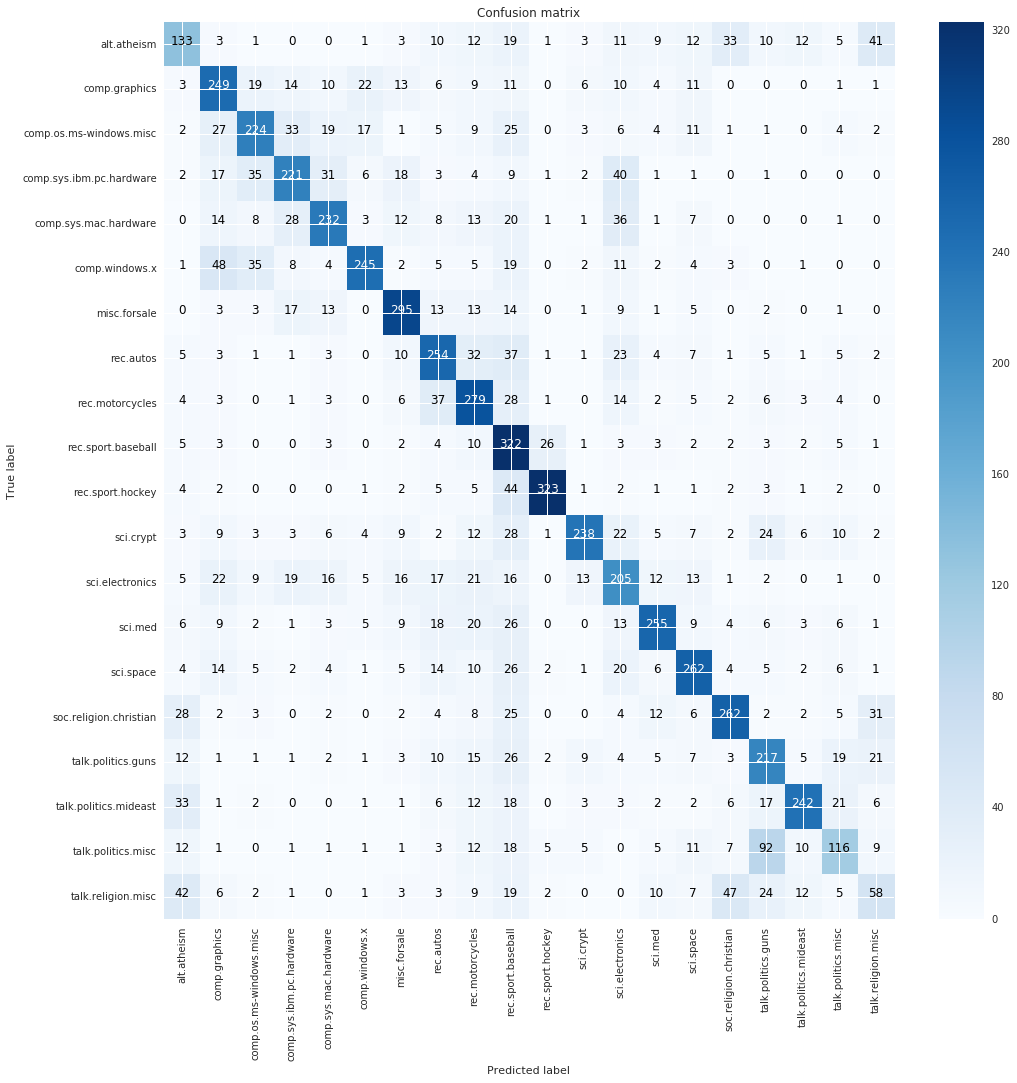

In [145]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm, classes)    

As an exercise, try playing with the training parameters and see if a better model can be made.

# Step 5: Instant prediction

The MLWorkbench also supports running prediction and displaying the results within the notebook. Note that we use the non-evaluation model below, so the target column is removed.

In [146]:
%%ml predict
model: $regular_model
headers: text
prediction_data:
  - nasa
  - windows xp

predicted,predicted_2,predicted_3,predicted_4,probability,probability_2,probability_3,probability_4,text
sci.space,rec.motorcycles,rec.sport.baseball,rec.autos,0.129271,0.069310,0.068492,0.060191,nasa
comp.os.ms-windows.misc,comp.graphics,rec.motorcycles,rec.sport.baseball,0.209872,0.064577,0.064133,0.060829,windows xp


## Feature Sensitivity Analysis using Lime

[LIME](https://github.com/marcotcr/lime) is an open sourced library performing feature sensitivity analysis. LIME is included in Datalab.

In this case, we use LIME to check what words are contributing most to predicted label.

Note that this library works better in local run. If your model is deployed online, predictions will be done with http round trips, and are restricted to http request size. Since LIME makes many predictions for a single instance, it is probably not a good idea to do it on deployed models.

In [147]:
import numpy as np
import google.datalab.contrib.mlworkbench as mlw
from tensorflow.python.lib.io import file_io
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups

In [148]:
news_test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
labels = news_train_data.target_names


# predict_fn is used in lime to perform feature sensitivity analysis.

def predict_fn(news_data):
    """Given a list of strings, get probabilities for each class for each instance."""
    
    news_data = [{'news': x} for x in news_data]
    df = mlw.get_prediction_results(regular_model, news_data, ['news'], with_source=False)
    probs = mlw.get_probs_for_labels(labels, df)
    return np.asarray(probs)

In [149]:
data = [
  'am little confused models 88 89 heard le se could someone tell differences far features performance am also curious book value 89 model much less than book value usually them words much demand time year heard mid spring early summer best time buy',
  'familiar format these face after seeing them folks headers ve got see them maybe make own ve got view linux box displays faces ve managed compile un too now looking them seem find face news headers could please send face header ll probably little handle hope',
  'let set record straight time read connection anything say due book okay guess hate book why hate going quote 20th edition book should familiar hate species humans during birth shortly risk infection clearly ever present indeed occurs most common play main role preventing infection low count sick see infection poor diet set many third world residents assessment correct dispute posted discussion without infection these responsible local sites gi mouth down competition proposed possible trigger let quote again however factors such use broad spectrum may both addressing term better course teach covers effect treatment well cure guess course does too bad detect little steve noticed rank according point displays capable producing cells true probably makes lot sense lot greek called go ahead still haven been able figure why such small little bring much people sci med must got into too keep hoping people take time think ve said make sense asking anyone here buy into connection book because book plain simple honest beginning wish never written',
  'hi requirement closing opening different display servers within application manner such time display associated client proper done during transition should problems',
  'were attacking drive them country whose citizens close blood business citizens thinks us had helped too least eastern muslim country doing much anything help protect indeed masses citizens were favor killed muslims because he killing relatively rich muslims also his nose west rolled back invasion were charge think very good idea governments official religion de de because human nature always ones rise power too many people world country citizens really leader really he slick operator make sound these guys angels posting edited stuff following friday new york times reported group definitely conservative than even his followers think house does rule country enough reported besides complaining government conservative enough approx 500 000 kingdom charge under islamic law brings death penalty guy bin isn he called severe punishment 40 women drove public while back protest ban women driving guy group said al said these women should fired their jobs want see happen ve heard many muslims say ban women driving basis etc yet these folks ban want these women called were choose rally behind anyone anyone hate say women should allowed work say tv radio too immoral kingdom now house neither least nor most favorite government earth think restrict religious political lot among things think most likely them going lot worse citizens country think house feeling heat lately last six months ve read been religious police government western women fully something stupid women imo because sends wrong signals morality ve read ve down few home based religious even posted government owned newspapers offering money anyone turns group dare worship their homes secret place government grown even try take wind conservative opposition these things re small taste happen these guys house re trying long run really others general west evil rule hate west crowd want',
]
df_prediction = mlw.get_prediction_results(regular_model, data, ['news'], with_source=False)
df_prediction

,predicted,predicted_2,predicted_3,predicted_4,probability,probability_2,probability_3,probability_4
0,rec.autos,comp.sys.mac.hardware,rec.sport.baseball,soc.religion.christian,0.357105,0.200559,0.074349,0.068791
1,sci.electronics,comp.graphics,comp.windows.x,rec.motorcycles,0.307947,0.252762,0.071596,0.054475
2,sci.med,alt.atheism,soc.religion.christian,talk.politics.misc,0.913852,0.043690,0.026557,0.005259
3,comp.windows.x,comp.graphics,comp.sys.mac.hardware,sci.med,0.603764,0.043139,0.039719,0.039250
4,talk.politics.guns,talk.politics.misc,talk.politics.mideast,alt.atheism,0.793546,0.080596,0.063762,0.060841


In [150]:
# Create a text explainer.

from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=labels)

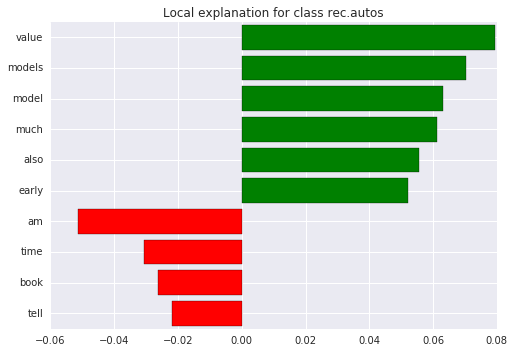

In [151]:
# Run analysis on instance 0 to understand what words contribute to label 'rec.autos'
label_index = labels.index('rec.autos')
exp = explainer.explain_instance(data[0], predict_fn, num_features=10, labels=[label_index])
_ = exp.as_pyplot_figure(label=label_index)

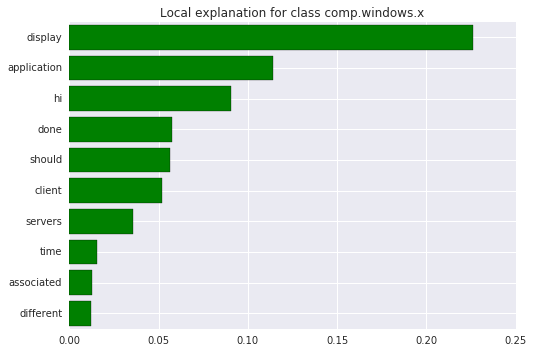

In [152]:
# Run analysis on instance 3 to understand what words contribute to label 'comp.windows.x'
label_index = labels.index('comp.windows.x')
exp = explainer.explain_instance(data[3], predict_fn, num_features=10, labels=[label_index])
_ = exp.as_pyplot_figure(label=label_index)

On instance 4, the top prediction result does not match truth. Predicted is "talk.politics.guns" while truth is "talk.politics.mideast". So let's analyze these two labels.

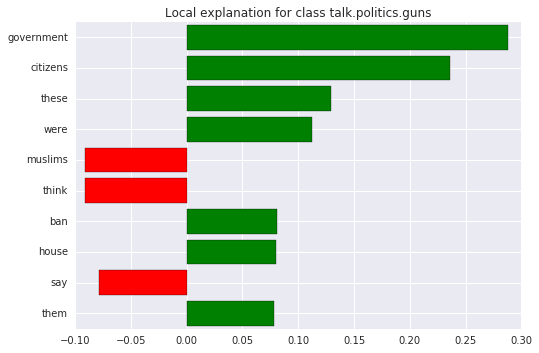

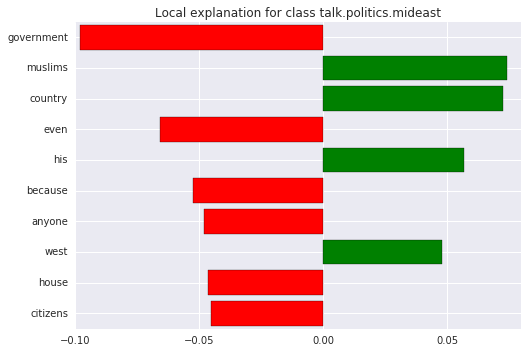

In [153]:
# Run analysis on instance 4.
predicted_label_index = labels.index('talk.politics.guns')
truth_label_index = labels.index('talk.politics.mideast')

exp = explainer.explain_instance(data[4], predict_fn, num_features=10, 
                                 labels=[predicted_label_index, truth_label_index])
_ = exp.as_pyplot_figure(label=predicted_label_index)
_ = exp.as_pyplot_figure(label=truth_label_index)